In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate, integrate, stats
import ligo.skymap.plot

ALPHA_1 = -2.16
ALPHA_2 = -1.46
A = 0.97
M_GAP_LO = 2.72
M_GAP_HI = 6.13
ETA_GAP_LO = 50
ETA_GAP_HI = 50
ETA_MIN = 50
ETA_MAX = 4.91
BETA = 1.89
M_MIN = 1.16
M_MAX = 54.38


def lopass(m, m_0, eta):
    return 1 / (1 + (m / m_0)**eta)


def hipass(m, m_0, eta):
    return 1 - lopass(m, m_0, eta)


def bandpass(m, m_lo, m_hi, eta_lo, eta_hi, A):
    return 1 - A * hipass(m, m_lo, eta_lo) * lopass(m, m_hi, eta_hi)


def pairing_function(m1, m2):
    # return np.where(m1 >= m2, (m2 / m1) ** BETA, 0)
    return np.where((m1 >= m2) & ((m1 <= 60) | (m2 >= 2.5)), (m2 / m1) ** BETA, 0)
    # m1, m2 = np.maximum(m1, m2), np.minimum(m1, m2)
    # return (m2 / m1) ** BETA


def mass_distribution_1d(m):
    return (
        bandpass(m, M_GAP_LO, M_GAP_HI, ETA_GAP_LO, ETA_GAP_HI, A) *
        hipass(m, M_MIN, ETA_MIN) *
        lopass(m, M_MAX, ETA_MAX) *
        (m / M_GAP_HI) ** np.where(m < M_GAP_HI, ALPHA_1, ALPHA_2)
    )


def mass_distribution_2d(m1, m2):
    return (
        mass_distribution_1d(m1) *
        mass_distribution_1d(m2) *
        pairing_function(m1, m2)
    )


# Hard limits on masses
M_MIN_HARD = 1
M_MAX_HARD = 100


def log_mass_distribution_2d(log_m1, log_m2):
    m1 = np.exp(log_m1)
    m2 = np.exp(log_m2)
    return m1 * m2 * mass_distribution_2d(m1, m2)


LOG_M_MIN_HARD = np.log(M_MIN_HARD)
LOG_M_MAX_HARD = np.log(M_MAX_HARD)

In [2]:
log_m = np.linspace(LOG_M_MIN_HARD, LOG_M_MAX_HARD, 1000)
d_log_m = log_m[1] - log_m[0]
log_m1, log_m2 = np.meshgrid(log_m, log_m)
p = log_mass_distribution_2d(log_m1, log_m2)
p /= p.sum() * d_log_m**2
P_log_m1 = integrate.cumulative_trapezoid(p.sum(0) * d_log_m, log_m, initial=0)
P_log_m2 = integrate.cumulative_trapezoid(p.sum(1) * d_log_m, log_m, initial=0)

In [3]:
# Generate synthetic data
# xx = log_m1.ravel()
# yy = log_m2.ravel()
# cs = np.cumsum(p.ravel() * d_log_m**2)
# rv = stats.uniform.rvs(size=1000)
# farah = Table({'mass1': np.exp(np.interp(rv, cs, xx)), 'mass2': np.exp(np.interp(rv, cs, yy))})

farah = Table.read('~/Documents/Research/observing-scenarios-simulations/farah.h5')
farah

mass1,mass2,spin1z,spin2z
float64,float64,float64,float64
1.6334784673051967,1.3810887548655666,0.0005726141112029242,-0.012026548338777296
2.4116235511053596,2.038928316809099,0.09564577831587825,0.12876640961108698
2.3446204414808824,2.1620985552733023,-0.0424013188343698,0.20299660662345526
1.5224413917381097,1.4464455008707857,0.056652858388635034,0.1648556391943954
2.071907865468317,1.757569633659934,0.0721102841575518,-0.06863285853206544
2.228580285753769,1.4524633465091121,-0.05540371265571241,-0.1265544612962752
2.5055269266513167,2.1706629048176076,-0.2000906209214,-0.051154897855052124
1.8555053747371508,1.8289801879174041,-0.11909810554860156,0.182958996341943
2.6627121633007507,2.1625491784606057,0.1485923978978139,-0.008017028311105538


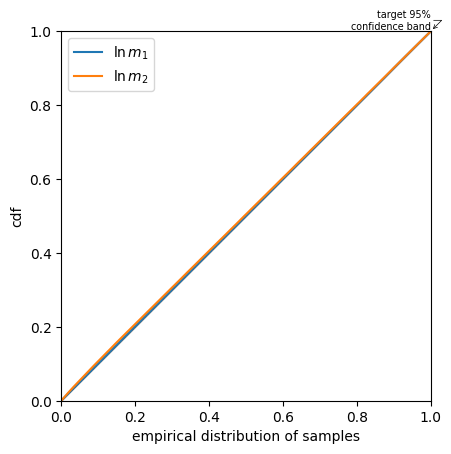

In [4]:
ax = plt.axes(projection='pp_plot')
ax.add_diagonal()
ax.add_confidence_band(len(farah))
ax.add_series(np.interp(np.log(farah['mass1']), log_m, P_log_m1), label=r'$\ln m_1$')
ax.add_series(np.interp(np.log(farah['mass2']), log_m, P_log_m2), label=r'$\ln m_2$')
ax.legend()
ax.set_xlabel('empirical distribution of samples')
ax.set_ylabel('cdf')
plt.savefig('farah.png')

Text(0.5, 0, '$\\ln m_1$')

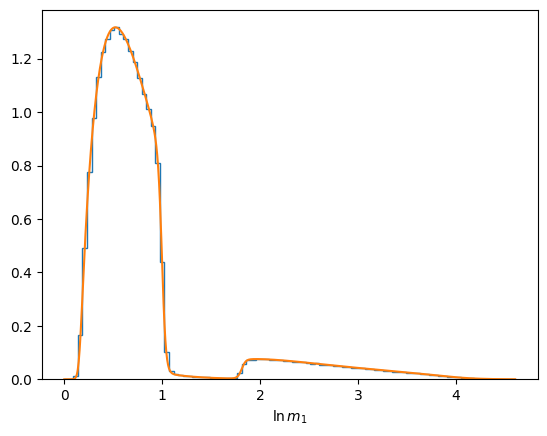

In [5]:
ax = plt.axes()
ax.hist(np.log(farah['mass1']), density=True, bins=np.linspace(LOG_M_MIN_HARD, LOG_M_MAX_HARD, 100), histtype='step')
ax.plot(log_m, p.sum(0) * d_log_m)
ax.set_xlabel(r'$\ln m_1$')

Text(0.5, 0, '$\\ln m_2$')

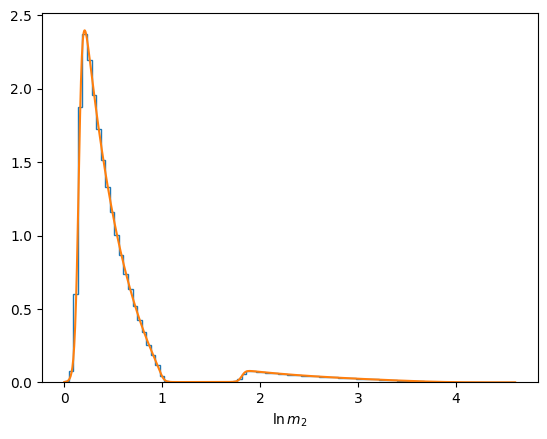

In [6]:
ax = plt.axes()
ax.hist(np.log(farah['mass2']), density=True, bins=np.linspace(LOG_M_MIN_HARD, LOG_M_MAX_HARD, 100), histtype='step')
ax.plot(log_m, p.sum(1) * d_log_m)
ax.set_xlabel(r'$\ln m_2$')